In [1]:
# Nonlinear MPC test using kinematic bicycle model for car
# We want to use the kinematic bicycle model from this paper (Figure 3)
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4

# which has states:
# x, y = positional coordinates in inertial frame
# ψ = angle of car centerline in inertial frame
# ̇ψ = change of angle
# β = angle between car centerline and velocity vector
# ̇β = change of angle

# and has the equations:
# ̇x = v cos(ψ + β)
# ̇y = v sin(ψ + β)
# ̇v = a
# ̇ψ = v / lᵣ sin(β)
# β = arctan(lᵣ/(lf + lᵣ) tan(δf))
# ̇β = v/(lf + lᵣ) tan(δf) - v/lᵣ sin(β)
# ̇δf = ω

# and we want to solve it. Define the model:


The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}
where the two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).
The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}
\end{gather*}

## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [2]:
# Library dependencies
import casadi
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import bezier

# Local dependencies
from direct_collocation  import MpcProblem
from KinematicBicycleCar import KinematicBicycleCar
from roadrunner_2        import Roadrunner, Segment
from road                import iso_double_lane_change as test_road

## Initial state and cost

In [3]:
# Initialize the car model with 0.05 second steps and 30 step lookahead
car = KinematicBicycleCar(N=30, step=0.075)

DESIRED_SPEED = 5.0

In [4]:
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road,                    # Road centerline points
                        road_width  = np.ones(n_test_road_pts)*5.0, # constant lane width of 5 meters
                        P           = 10) # Number of points to try curve-fitting at a time



In [5]:
# Boundary functions

# terrible hack, need to fix right away

global dist_already_traveled
dist_already_traveled = 0.0

def road_center(model:KinematicBicycleCar, k:int)->np.array:
    global dist_already_traveled

    (xy, angle, _) = roadrunner.evaluate(model.step*np.sum(model.state_estimate[2,:k]), full_data=True)

    center = np.empty((3,))
    center[0:2] = np.reshape(xy, 2)
    center[2]   = angle
    return center

# Test

def bound_x(model:KinematicBicycleCar, k:int)->[np.array]:
    # Returns a 4-sided polygon bound, like this:
    # x2-------x3
    #   \  o  /
    #  x1-----x4
    # successive bounds will overlap each other
    # so there is freedom to slow down or speed up the vehicle.
    
    dist_behind = (k-5)*model.step*DESIRED_SPEED # 5 steps behind * timestep * velocity at point k
    #print("Looking behind by", dist_behind)
    (center_minus, angle_minus, width_minus) = roadrunner.evaluate(dist_behind, full_data=True)
    
    dist_ahead = (k+5)*model.step*DESIRED_SPEED # 5 steps ahead * timestep * velocity at point k
    #print("Looking ahead by", dist_ahead)
    (center_plus, angle_plus, width_plus) = roadrunner.evaluate(dist_ahead, full_data=True)

    center_minus = np.reshape(center_minus,(2,))
    center_plus = np.reshape(center_plus,(2,))
    
    #print("Got center points", center_minus, center_plus)
    #print("center angles:", 180.0/np.pi*(angle_minus), 180.0/np.pi*(angle_plus))
    # These four points define the 2d bounding box for the car at state xk
    
    p1 = np.reshape(np.array([center_minus[0] + width_minus/2.0*np.cos(angle_minus-np.pi/2),
                   center_minus[1] + width_minus/2.0*np.sin(angle_minus-np.pi/2)]), (2,))
    
    p2 = np.reshape(np.array([center_minus[0] + width_minus/2.0*np.cos(angle_minus+np.pi/2),
                   center_minus[1] + width_minus/2.0*np.sin(angle_minus+np.pi/2)]), (2,))
    
    p3 = np.reshape(np.array([center_plus[0] + width_plus/2.0*np.cos(angle_plus+np.pi/2),
                   center_plus[1] + width_plus/2.0*np.sin(angle_plus+np.pi/2)]), (2,))
    
    p4 = np.reshape(np.array([center_plus[0] + width_plus/2.0*np.cos(angle_plus-np.pi/2),
                   center_plus[1] + width_plus/2.0*np.sin(angle_plus-np.pi/2)]), (2,))
    
    # The slopes between the points
    slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isnan(slope12) else slope12
    slope23 = (p3[1]-p2[1])/(p3[0]-p2[0]); slope23 = 1e4 if np.isnan(slope23) else slope23
    slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isnan(slope43) else slope43
    slope14 = (p1[1]-p4[1])/(p1[0]-p4[0]); slope14 = 1e4 if np.isnan(slope14) else slope14

    # form 4 linear inequalities to represent the box
    # we either have 0.0 >= ax + by + c >= -Inf
    # or             Inf >= ax + by + c >= 0.0
    
    # since y = (x-x0)*slope + y0
    # use the line 0 = x*slope - y + y0 - x0*slope as the upper / lower bound
    
    #            (upper)
    #     p2-----slope23------p3
    #    /                    /
    # slope12 (upper)   slope34 (lower)
    #  /                   /
    # p1-----slope14-----p4
    #        (lower)
    
    # upper bounds (if slope is positive)
    bounds = [
        np.array([np.inf, slope12, -1.0, (p1[1]-p1[0]*slope12), 0.0 - 0]),
        np.array([np.inf, slope23, -1.0, (p2[1]-p2[0]*slope23), 0.0 - 3]),
    
    # lower bounds (if slope is positive)
        np.array([0.0 + 0, slope43, -1.0, (p4[1]-p4[0]*slope43), -np.inf]),
        np.array([0.0 + 3, slope14, -1.0, (p1[1]-p1[0]*slope14), -np.inf]),
    ]
    
    for i in range(len(bounds)): # Handle the negative-slope flipped cases
    
        if np.sign(bounds[i][1]) == -1: # slope is negative, so inequality flips
            bounds[i][0], bounds[i][4] = -bounds[i][4], -bounds[i][0]
            
    return bounds, np.vstack([p1,p2,p3,p4])


In [6]:
# What we should do now
# 1. Use the velocity estimate to "step through" the road,
#    obtaining a set of road midpoints and constraint boundaries
# 2. Add a term to the cost function that attracts the successive states to the road midpoints - done
# 3. Use the midpoints to initialize the variable estimate so the solver is faster. - done,
#    and we are initializing the new control uk to the previously computed one
#    kind of warm-starting ipopt - done


## Run the MPC algorithm

In [7]:
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(car.step*7*DESIRED_SPEED)

xy = np.reshape(roadrunner.evaluate(),(2,))
ic = [xy[0], xy[1], DESIRED_SPEED, float(roadrunner.get_angle())]
car.set_initial(ic)
print("Starting at initial conditions", ic)

# This is the model:
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1/figures/3
mpcprob = MpcProblem(car,     # casadi.DaeBuilder()
                     bound_x=bound_x,
                     road_center=road_center,
                    )


# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs = 170

x_plan = np.empty((mpcprob.model.n,n_runs+1)) # store the steps that get executed (n_runs)
u_plan = np.empty((mpcprob.model.m,n_runs))   # store the control inputs that get executed
x_true = np.empty((mpcprob.model.n,n_runs+1)) # store the state as simulated for each control input by an integrator
x_true[:,0] = ic # initial conditions
x_plan[:,0] = ic
# store the polygon boundary for each step, so we can plot them later
polygon_boundaries = np.zeros((n_runs+mpcprob.model.N,4,2))

for k in range(n_runs):
    # Solve the MPC problem
    xk_opt, uk_opt, sol = mpcprob.run(x_true[:,k])
    
    # Save the next state x_k+1 and control u_k+1
    for i in range(mpcprob.model.n):
        x_plan[i,k+1] = xk_opt[i][1]
    for i in range(mpcprob.model.m):
        u_plan[i,k] = uk_opt[i][1]
    x_true[:,k+1] = mpcprob.simulate(x_true[:,k], u_plan[:,k])
    
    # Compute distance traveled (approximately)
    step_xy = np.linalg.norm(x_true[:,k+1]-x_true[:,k], 2) #np.sqrt((x_true[0,k+1]-x_true[0,k])**2 + (x_true[1,k+1]-x_true[1,k])**2)
    
    # Save the 4 points that represent the polygon boundary at state k
    bounds,p = bound_x(mpcprob.model,0)
    polygon_boundaries[k,:,:] = p
    
    roadrunner.advance(step_xy)
    print("Advanced by", step_xy,"to", roadrunner.evaluate())

    # Done!

Starting at initial conditions [7.973393420909675, 0.9523902139751268, 5.0, 0.0022467447187692127]
Attracting  X_1[0] 1 to  [8.35529335e+00 9.53264014e-01 2.24674472e-03]
Attracting  X_2[0] 2 to  [8.73556648e+00 9.54166553e-01 2.24674472e-03]
Attracting  X_3[0] 3 to  [9.11412869e+00 9.55100336e-01 2.24674472e-03]
Attracting  X_4[0] 4 to  [9.49088901e+00 9.56069903e-01 2.24674472e-03]
Attracting  X_5[0] 5 to  [9.86575201e+00 9.57082054e-01 2.24674472e-03]
Attracting  X_6[0] 6 to  [1.02386208e+01 9.58146074e-01 2.24674472e-03]
Attracting  X_7[0] 7 to  [1.06094001e+01 9.59273960e-01 2.24674472e-03]
Attracting  X_8[0] 8 to  [1.09780008e+01 9.60480648e-01 2.24674472e-03]
Attracting  X_9[0] 9 to  [1.13443435e+01 9.61784222e-01 2.24674472e-03]
Attracting  X_10[0] 10 to  [1.17083631e+01 9.63206131e-01 2.24674472e-03]
Attracting  X_11[0] 11 to  [1.20700141e+01 9.64771379e-01 2.24674472e-03]
Attracting  X_12[0] 12 to  [1.24292752e+01 9.66508711e-01 2.24674472e-03]
Attracting  X_13[0] 13 to  [1.2

Advanced by 0.37465365121436567 to [[8.7351746  0.95416561]]
Attracting  X_1[0] 1 to  [9.11270822e+00 9.55096761e-01 2.41819919e-03]
Attracting  X_2[0] 2 to  [9.48729514e+00 9.56060443e-01 2.41819919e-03]
Attracting  X_3[0] 3 to  [9.85850113e+00 9.57061967e-01 2.41819919e-03]
Attracting  X_4[0] 4 to  [1.02258226e+01 9.58108471e-01 2.41819919e-03]
Attracting  X_5[0] 5 to  [1.05887517e+01 9.59209052e-01 2.41819919e-03]
Attracting  X_6[0] 6 to  [1.09468319e+01 9.60374843e-01 2.41819919e-03]
Attracting  X_7[0] 7 to  [1.12997034e+01 9.61619055e-01 2.41819919e-03]
Attracting  X_8[0] 8 to  [1.16471378e+01 9.62957012e-01 2.41819919e-03]
Attracting  X_9[0] 9 to  [1.19890609e+01 9.64406215e-01 2.41819919e-03]
Attracting  X_10[0] 10 to  [1.23255654e+01 9.65986466e-01 2.41819919e-03]
Attracting  X_11[0] 11 to  [1.26569125e+01 9.67720083e-01 2.41819919e-03]
Attracting  X_12[0] 12 to  [1.29835245e+01 9.69632231e-01 2.41819919e-03]
Attracting  X_13[0] 13 to  [1.33059699e+01 9.71751357e-01 2.41819919e

   3  8.0570628e-01 2.44e-06 1.66e-03  -1.0 3.51e+00    -  9.79e-01 1.00e+00f  1
   4  5.7425190e-01 5.93e-06 1.70e-04  -1.7 3.22e+00    -  1.00e+00 1.00e+00f  1
   5  5.6057027e-01 1.28e-06 1.65e-05  -2.5 8.25e-01    -  1.00e+00 1.00e+00f  1
   6  5.6009279e-01 5.33e-08 5.30e-07  -3.8 1.46e-01    -  1.00e+00 1.00e+00h  1
   7  5.6009131e-01 1.76e-10 1.66e-09  -5.7 8.12e-03    -  1.00e+00 1.00e+00h  1
   8  5.6009131e-01 4.21e-14 1.51e-13  -8.6 6.95e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   5.6009130780521499e-01    5.6009130780521499e-01
Dual infeasibility......:   1.5121812137842755e-13    1.5121812137842755e-13
Constraint violation....:   4.2077452633293433e-14    4.2077452633293433e-14
Complementarity.........:   2.5445344846896585e-09    2.5445344846896585e-09
Overall NLP error.......:   2.5445344846896585e-09    2.5445344846896585e-09


Number of objective functi

Attracting  X_26[0] 26 to  [17.98619929  1.1057241   0.05064501]
Attracting  X_27[0] 27 to  [18.35103647  1.1249799   0.05483863]
Attracting  X_28[0] 28 to  [18.72319912  1.14623047  0.05926273]
Attracting  X_29[0] 29 to  [19.10258204  1.16962345  0.06392899]
Attracting  X_30[0] 30 to  [19.48906314  1.19531391  0.06884936]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of ine

Attracting  X_24[0] 24 to  [17.52587487  1.08357458  0.04555137]
Attracting  X_25[0] 25 to  [17.87313504  1.10006524  0.04937367]
Attracting  X_26[0] 26 to  [18.22968018  1.1184042   0.05342813]
Attracting  X_27[0] 27 to  [18.59546581  1.13875036  0.05772739]
Attracting  X_28[0] 28 to  [18.97040013  1.16127097  0.06228501]
Attracting  X_29[0] 29 to  [19.35436214  1.18614273  0.06711508]
Attracting  X_30[0] 30 to  [19.74721822  1.21355292  0.07223171]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                 

Attracting  X_29[0] 29 to  [19.85966121  1.22177352  0.07372916]
Attracting  X_30[0] 30 to  [20.24201681  1.25101028  0.07893162]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality con

Attracting  X_24[0] 24 to  [18.75256297  1.14797793  0.0596182 ]
Attracting  X_25[0] 25 to  [19.12081757  1.17079291  0.06415733]
Attracting  X_26[0] 26 to  [19.48903219  1.19531177  0.06884896]
Attracting  X_27[0] 27 to  [19.85648436  1.22153893  0.07368665]
Attracting  X_28[0] 28 to  [20.22281835  1.24949432  0.07866633]
Attracting  X_29[0] 29 to  [20.58789569  1.27920857  0.08378429]
Attracting  X_30[0] 30 to  [20.95168911  1.31071794  0.08903558]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                 

Attracting  X_25[0] 25 to  [19.80968189  1.21809868  0.07306174]
Attracting  X_26[0] 26 to  [20.17673343  1.24587622  0.07803126]
Attracting  X_27[0] 27 to  [20.54330985  1.27547844  0.08315101]
Attracting  X_28[0] 28 to  [20.90918459  1.30693681  0.08841441]
Attracting  X_29[0] 29 to  [21.27429446  1.34029154  0.09381383]
Attracting  X_30[0] 30 to  [21.63866615  1.37558722  0.09933946]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of eq

Attracting  X_18[0] 18 to  [17.93816006  1.10330213  0.05010322]
Attracting  X_19[0] 19 to  [18.27302328  1.12073305  0.0539301 ]
Attracting  X_20[0] 20 to  [18.61536699  1.13990285  0.05796543]
Attracting  X_21[0] 21 to  [18.9643005   1.16089079  0.06220962]
Attracting  X_22[0] 22 to  [19.31885953  1.18376448  0.06666145]
Attracting  X_23[0] 23 to  [19.67807921  1.20858196  0.07131827]
Attracting  X_24[0] 24 to  [20.04107242  1.23539572  0.07617621]
Attracting  X_25[0] 25 to  [20.40711183  1.26425918  0.08123064]
Attracting  X_26[0] 26 to  [20.77569776  1.29523436  0.08647662]
Attracting  X_27[0] 27 to  [21.14655339  1.32839532  0.09190854]
Attracting  X_28[0] 28 to  [21.51956606  1.36382642  0.09751898]
Attracting  X_29[0] 29 to  [21.89473512  1.40161969  0.10329782]
Attracting  X_30[0] 30 to  [22.27212844  1.44187149  0.10923148]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of no

   6  1.0342838e+00 7.68e-06 1.85e-03  -2.5 1.43e+00    -  9.73e-01 1.00e+00f  1
   7  8.7578184e-01 7.10e-07 1.19e-05  -2.5 3.04e-01    -  1.00e+00 1.00e+00f  1
   8  8.5430139e-01 3.00e-07 1.94e-02  -3.8 1.12e-01    -  1.00e+00 5.97e-01f  1
   9  8.5424999e-01 1.75e-08 1.67e-06  -3.8 7.91e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.5384682e-01 7.61e-10 6.46e-04  -5.7 6.53e-03    -  1.00e+00 9.56e-01h  1
  11  8.5384864e-01 2.61e-13 1.08e-10  -5.7 4.50e-04    -  1.00e+00 1.00e+00f  1
  12  8.5384679e-01 4.85e-14 2.42e-12  -8.6 9.30e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   8.5384678868074970e-01    8.5384678868074970e-01
Dual infeasibility......:   2.4205843742677467e-12    2.4205843742677467e-12
Constraint violation....:   4.8461235024888083e-14    4.8461235024888083e-14
Complementarity....

Attracting  X_30[0] 30 to  [23.08666016  1.53658715  0.12234766]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    i

Attracting  X_27[0] 27 to  [22.44386055  1.4609424   0.11196608]
Attracting  X_28[0] 28 to  [22.81412181  1.50368797  0.11792213]
Attracting  X_29[0] 29 to  [23.18923219  1.54928664  0.12402006]
Attracting  X_30[0] 30 to  [23.56930159  1.59786585  0.1302384 ]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality c

Attracting  X_26[0] 26 to  [22.57877313  1.47625902  0.11412752]
Attracting  X_27[0] 27 to  [22.93789892  1.51847793  0.11992842]
Attracting  X_28[0] 28 to  [23.30103679  1.56332785  0.12584631]
Attracting  X_29[0] 29 to  [23.66826419  1.61090962  0.13186092]
Attracting  X_30[0] 30 to  [24.03965803  1.66131943  0.13795174]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of ine

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_29[0] 29 to  [24.65679446  1.75017791  0.02906025]
Attracting  X_30[0] 30 to  [24.97111985  1.810938    0.16728773]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality con

Attracting  X_29[0] 29 to  [25.10107806  1.83300377  0.16908383]
Attracting  X_30[0] 30 to  [25.47703295  1.89817622  0.17418396]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality con

Attracting  X_23[0] 23 to  [23.50642454  1.58966318  0.03905089]
Attracting  X_24[0] 24 to  [23.8557376   1.63606769  0.03905089]
Attracting  X_25[0] 25 to  [24.20857763  1.68500948  0.03905089]
Attracting  X_26[0] 26 to  [24.56434241  1.73646167  0.03905089]
Attracting  X_27[0] 27 to  [24.86476188  1.79305876  0.16580473]
Attracting  X_28[0] 28 to  [25.23665216  1.85627782  0.17093922]
Attracting  X_29[0] 29 to  [25.60740105  1.9212336   0.17592006]
Attracting  X_30[0] 30 to  [25.97646813  1.98776142  0.18074567]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                

Attracting  X_20[0] 20 to  [22.97835715  1.5233669   0.04439812]
Attracting  X_21[0] 21 to  [23.3163753   1.56527035  0.04439812]
Attracting  X_22[0] 22 to  [23.65877168  1.60965138  0.04439812]
Attracting  X_23[0] 23 to  [24.0046157   1.65646464  0.04439812]
Attracting  X_24[0] 24 to  [24.352937    1.70563274  0.04439812]
Attracting  X_25[0] 25 to  [24.7027817   1.7570536   0.04439812]
Attracting  X_26[0] 26 to  [25.0001097  1.8158394  0.1676899]
Attracting  X_27[0] 27 to  [25.36106937  1.87786343  0.17262575]
Attracting  X_28[0] 28 to  [25.71879092  1.94111861  0.17739039]
Attracting  X_29[0] 29 to  [26.07278627  2.00542427  0.18198322]
Attracting  X_30[0] 30 to  [26.42267866  2.07061434  0.18640048]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzero

Attracting  X_28[0] 28 to  [26.19962234  2.02887067  0.18359887]
Attracting  X_29[0] 29 to  [26.55333735  2.09536483  0.1880172 ]
Attracting  X_30[0] 30 to  [26.90405996  2.16287085  0.19226114]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constra

Attracting  X_25[0] 25 to  [25.60984153  1.92166746  0.1759524 ]
Attracting  X_26[0] 26 to  [25.96712098  1.98605391  0.18062508]
Attracting  X_27[0] 27 to  [26.32203556  2.05169952  0.18514276]
Attracting  X_28[0] 28 to  [26.67397774  2.11841086  0.18949322]
Attracting  X_29[0] 29 to  [27.02252005  2.18601719  0.19366055]
Attracting  X_30[0] 30 to  [27.36740849  2.25437153  0.19762432]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of eq

Attracting  X_16[0] 16 to  [23.06936422  1.53446288  0.0615597 ]
Attracting  X_17[0] 17 to  [23.38567406  1.57409524  0.0615597 ]
Attracting  X_18[0] 18 to  [23.70967796  1.61641666  0.0615597 ]
Attracting  X_19[0] 19 to  [24.0406451   1.66145648  0.0615597 ]
Attracting  X_20[0] 20 to  [24.37767963  1.70920241  0.0615597 ]
Attracting  X_21[0] 21 to  [24.7197532   1.75959994  0.0615597 ]
Attracting  X_22[0] 22 to  [25.01299139  1.81802119  0.16786832]
Attracting  X_23[0] 23 to  [25.37210869  1.87978911  0.17277465]
Attracting  X_24[0] 24 to  [25.73021481  1.94316751  0.17754051]
Attracting  X_25[0] 25 to  [26.08605046  2.0078663   0.18215293]
Attracting  X_26[0] 26 to  [26.43851399  2.07360233  0.1865974 ]
Attracting  X_27[0] 27 to  [26.78673     2.14011601  0.1908576 ]
Attracting  X_28[0] 28 to  [27.13014178  2.2071941   0.19491575]
Attracting  X_29[0] 29 to  [27.46849518  2.27467235  0.19875181]
Attracting  X_30[0] 30 to  [27.80172637  2.34241737  0.20234188]
This is Ipopt version 3.1

Attracting  X_16[0] 16 to  [23.49352503  1.58798851  0.06763034]
Attracting  X_17[0] 17 to  [23.81297576  1.63027758  0.06763034]
Attracting  X_18[0] 18 to  [24.14120477  1.67550366  0.06763034]
Attracting  X_19[0] 19 to  [24.47729731  1.72367777  0.06763034]
Attracting  X_20[0] 20 to  [24.8200648   1.7747482   0.06763034]
Attracting  X_21[0] 21 to  [25.1185966   1.8359966   0.16932463]
Attracting  X_22[0] 22 to  [25.47972433  1.89864986  0.17421996]
Attracting  X_23[0] 23 to  [25.83973445  1.96289969  0.17897325]
Attracting  X_24[0] 24 to  [26.19654768  2.0282998   0.18355989]
Attracting  X_25[0] 25 to  [26.54830117  2.09440679  0.18795523]
Attracting  X_26[0] 26 to  [26.89351724  2.16081923  0.19213572]
Attracting  X_27[0] 27 to  [27.23128138  2.22722265  0.19608056]
Attracting  X_28[0] 28 to  [27.56122153  2.29339774  0.19977103]
Attracting  X_29[0] 29 to  [27.8833122   2.35919073  0.20318821]
Attracting  X_30[0] 30 to  [28.19772843  2.42448874  0.20631188]
This is Ipopt version 3.1

  11  4.0488115e+00 9.35e-12 2.28e-08  -5.7 6.09e-04    -  1.00e+00 1.00e+00f  1
  12  4.0488061e+00 7.39e-14 7.88e-07  -8.6 5.95e-05    -  1.00e+00 1.00e+00h  1
  13  4.0488061e+00 5.70e-14 3.65e-14  -8.6 6.77e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   4.0488060736701765e+00    4.0488060736701765e+00
Dual infeasibility......:   3.6526337510167650e-14    3.6526337510167650e-14
Constraint violation....:   5.6954441163270531e-14    5.6954441163270531e-14
Complementarity.........:   2.5059286708069737e-09    2.5059286708069737e-09
Overall NLP error.......:   2.5059286708069737e-09    2.5059286708069737e-09


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 14
Number of inequality constraint evaluations          = 14
Number of equality constraint Jacobi

Attracting  X_20[0] 20 to  [25.46337374  1.89577393  0.1740011 ]
Attracting  X_21[0] 21 to  [25.82138935  1.95958316  0.17873406]
Attracting  X_22[0] 22 to  [26.17708277  2.02468863  0.18331293]
Attracting  X_23[0] 23 to  [26.52805554  2.09055868  0.18770582]
Attracting  X_24[0] 24 to  [26.87226633  2.15668797  0.19188249]
Attracting  X_25[0] 25 to  [27.2082277   2.2226466   0.19581636]
Attracting  X_26[0] 26 to  [27.53512568  2.28811794  0.19948569]
Attracting  X_27[0] 27 to  [27.85271792  2.35289237  0.20287246]
Attracting  X_28[0] 28 to  [28.16111573  2.41683279  0.2059602 ]
Attracting  X_29[0] 29 to  [28.46062102  2.47984608  0.20873299]
Attracting  X_30[0] 30 to  [28.75162206  2.54186366  0.21117544]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonz

Attracting  X_26[0] 26 to  [27.93455753  2.36976291  0.20371264]
Attracting  X_27[0] 27 to  [28.24109616  2.43357451  0.20672405]
Attracting  X_28[0] 28 to  [28.53900159  2.49647665  0.20941694]
Attracting  X_29[0] 29 to  [28.82871838  2.55841527  0.21177584]
Attracting  X_30[0] 30 to  [29.1107037  2.6193461  0.2137864]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequa

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_16[0] 16 to  [25.4137472   1.88706767  0.17333522]
Attracting  X_17[0] 17 to  [25.75157625  1.94700348  0.17782087]
Attracting  X_18[0] 18 to  [26.09243629  2.00904281  0.18223458]
Attracting  X_19[0] 19 to  [26.43367816  2.07268951  0.18653729]
Attracting  X_20[0] 20 to  [26.77268801  2.1374042   0.1906885 ]
Attracting  X_21[0] 21 to  [27.10707469  2.20264335  0.19464806]
Attracting  X_22[0] 22 to  [27.43486084  2.26790455  0.19837852]
Attracting  X_23[0] 23 to  [27.75467391  2.33277669  0.20184763]
Attracting  X_24[0] 24 to  [28.06593885  2.39699415  0.2050306 ]
Attracting  X_25[0] 25 to  [28.36880067  2.46043619  0.20790894]
Attracting  X_26[0] 26 to  [28.6638133   2.52307229  0.21046697]
Attracting  X_27[0] 27 to  [28.95169935  2.58491553  0.21268965]
Attracting  X_28[0] 28 to  [29.23318344  2.64598735  0.21456194]
Attracting  X_29[0] 29 to  [29.50890025  2.70629648  0.21606925]
Attracting  X_30[0] 30 to  [29.77937949  2.76583424  0.21719901]
This is Ipopt version 3.1

Attracting  X_24[0] 24 to  [28.42243436  2.47176422  0.20839321]
Attracting  X_25[0] 25 to  [28.71603985  2.53424112  0.21089145]
Attracting  X_26[0] 26 to  [29.00261312  2.59592034  0.21305152]
Attracting  X_27[0] 27 to  [29.28308844  2.6568703   0.21485981]
Attracting  X_28[0] 28 to  [29.55832807  2.71715177  0.21630249]
Attracting  X_29[0] 29 to  [29.8290402   2.77679779  0.21736637]
Attracting  X_30[0] 30 to  [30.095782    2.83581254  0.2180408 ]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                 

Attracting  X_27[0] 27 to  [29.60176198  2.72670042  0.21649774]
Attracting  X_28[0] 28 to  [29.87248441  2.78639582  0.21750221]
Attracting  X_29[0] 29 to  [30.14008809  2.84563091  0.21811514]
Attracting  X_30[0] 30 to  [30.40515455  2.90441938  0.21832751]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality c

Attracting  X_24[0] 24 to  [29.08890796  2.6146158   0.21364194]
Attracting  X_25[0] 25 to  [29.36736168  2.67528245  0.21533815]
Attracting  X_26[0] 26 to  [29.6410586   2.73534701  0.21666647]
Attracting  X_27[0] 27 to  [29.91117296  2.79494824  0.2176148 ]
Attracting  X_28[0] 28 to  [30.17874522  2.85420008  0.21817102]
Attracting  X_29[0] 29 to  [30.44459277  2.91316927  0.21832451]
Attracting  X_30[0] 30 to  [30.70932609  2.97187719  0.21806841]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                 

Attracting  X_30[0] 30 to  [31.01070021  3.03854789  0.21727447]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    i

Attracting  X_25[0] 25 to  [29.97707015  2.8095253   0.21778814]
Attracting  X_26[0] 26 to  [30.24383067  2.86863221  0.21824605]
Attracting  X_27[0] 27 to  [30.50961858  2.92759525  0.21829976]
Attracting  X_28[0] 28 to  [30.7755853   2.98655539  0.21793969]
Attracting  X_29[0] 29 to  [31.04264698  3.04559852  0.21715914]
Attracting  X_30[0] 30 to  [31.31149019  3.10475583  0.21595666]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of eq

Attracting  X_27[0] 27 to  [30.80240523  2.99249402  0.21788022]
Attracting  X_28[0] 28 to  [31.06992997  3.05161673  0.21705596]
Attracting  X_29[0] 29 to  [31.33997014  3.11100145  0.2158054 ]
Attracting  X_30[0] 30 to  [31.61326355  3.17068232  0.21413043]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality c

Attracting  X_29[0] 29 to  [31.63750054  3.17595088  0.21396289]
Attracting  X_30[0] 30 to  [31.91704528  3.23638852  0.21181975]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality con

Attracting  X_18[0] 18 to  [28.94759254  2.5840287   0.21266004]
Attracting  X_19[0] 19 to  [29.22869926  2.64501024  0.21453465]
Attracting  X_20[0] 20 to  [29.50513593  2.70547026  0.21605101]
Attracting  X_21[0] 21 to  [29.77704844  2.76531983  0.21719085]
Attracting  X_22[0] 22 to  [30.04535009  2.82464122  0.21794292]
Attracting  X_23[0] 23 to  [30.31147383  2.88363602  0.21829844]
Attracting  X_24[0] 24 to  [30.57724601  2.94259568  0.21824771]
Attracting  X_25[0] 25 to  [30.84488656  3.00189691  0.21777736]
Attracting  X_26[0] 26 to  [31.11682727  3.06195444  0.21686856]
Attracting  X_27[0] 27 to  [31.39535647  3.12313437  0.21549844]
Attracting  X_28[0] 28 to  [31.68240748  3.18570121  0.21364454]
Attracting  X_29[0] 29 to  [31.97949254  3.24980033  0.21129033]
Attracting  X_30[0] 30 to  [32.2877925   3.3154777   0.20842946]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of no

Attracting  X_30[0] 30 to  [32.68023821  3.37840966  0.19175722]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    i

Attracting  X_28[0] 28 to  [32.30803194  3.31975624  0.17311205]
Attracting  X_29[0] 29 to  [32.67185631  3.37678182  0.19188419]
Attracting  X_30[0] 30 to  [32.98813108  3.43744314  0.18712078]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constra

Attracting  X_26[0] 26 to  [32.01607524  3.25764095  0.17807564]
Attracting  X_27[0] 27 to  [32.31418051  3.32105517  0.17807564]
Attracting  X_28[0] 28 to  [32.6793381   3.3782349   0.19177086]
Attracting  X_29[0] 29 to  [32.99774793  3.43926324  0.18697684]
Attracting  X_30[0] 30 to  [33.32474957  3.50030296  0.18211514]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of ine

Attracting  X_30[0] 30 to  [33.66768834  3.56256363  0.17708391]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    i

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_19[0] 19 to  [30.87342731  3.00821149  0.19135633]
Attracting  X_20[0] 20 to  [31.14963254  3.06918018  0.19135633]
Attracting  X_21[0] 21 to  [31.4303069   3.13078125  0.19135633]
Attracting  X_22[0] 22 to  [31.71597552  3.1929797   0.19135633]
Attracting  X_23[0] 23 to  [32.00709211  3.25571676  0.19135633]
Attracting  X_24[0] 24 to  [32.30421933  3.31895059  0.19135633]
Attracting  X_25[0] 25 to  [32.66847403  3.37612464  0.19193543]
Attracting  X_26[0] 26 to  [32.98711654  3.43725104  0.18713596]
Attracting  X_27[0] 27 to  [33.31602459  3.49869563  0.18224404]
Attracting  X_28[0] 28 to  [33.65564215  3.56040677  0.1772595 ]
Attracting  X_29[0] 29 to  [34.00606456  3.62226201  0.17218346]
Attracting  X_30[0] 30 to  [34.36723943  3.68410947  0.16701524]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of non

Attracting  X_22[0] 22 to  [31.99413473  3.25293999  0.19522962]
Attracting  X_23[0] 23 to  [32.29088214  3.31613111  0.19522962]
Attracting  X_24[0] 24 to  [32.65436081  3.37338049  0.19214932]
Attracting  X_25[0] 25 to  [32.97239055  3.43446098  0.18735648]
Attracting  X_26[0] 26 to  [33.30074189  3.49587741  0.18246992]
Attracting  X_27[0] 27 to  [33.63988653  3.55758244  0.17748929]
Attracting  X_28[0] 28 to  [33.98986078  3.61944213  0.17241678]
Attracting  X_29[0] 29 to  [34.35042469  3.68127268  0.16725456]
Attracting  X_30[0] 30 to  [34.72137388  3.74289738  0.16200048]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
               

   9  9.1109408e+01 1.04e-09 1.69e-06  -3.8 6.22e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.1108049e+01 2.43e-11 4.21e-07  -5.7 2.04e-03    -  1.00e+00 1.00e+00f  1
  11  9.1108034e+01 1.19e-13 1.45e-10  -8.6 1.34e-04    -  1.00e+00 1.00e+00h  1
  12  9.1108034e+01 8.21e-14 6.04e-14  -8.6 5.21e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   9.1108034195226850e+01    9.1108034195226850e+01
Dual infeasibility......:   6.0396132539608516e-14    6.0396132539608516e-14
Constraint violation....:   8.2100992671030326e-14    8.2100992671030326e-14
Complementarity.........:   2.5066902548087043e-09    2.5066902548087043e-09
Overall NLP error.......:   2.5066902548087043e-09    2.5066902548087043e-09


Number of objective function evaluations             = 13
Number of objective gradient evaluations        

Attracting  X_19[0] 19 to  [31.52618678  3.15171962  0.20047602]
Attracting  X_20[0] 20 to  [31.81672231  3.21477144  0.20047602]
Attracting  X_21[0] 21 to  [32.11169156  3.27807538  0.20047602]
Attracting  X_22[0] 22 to  [32.41164584  3.34159219  0.20047602]
Attracting  X_23[0] 23 to  [32.78025184  3.39774808  0.19024526]
Attracting  X_24[0] 24 to  [33.10132682  3.45877597  0.18543002]
Attracting  X_25[0] 25 to  [33.43268393  3.52009086  0.18052431]
Attracting  X_26[0] 26 to  [33.77493278  3.58166957  0.17552418]
Attracting  X_27[0] 27 to  [34.12809476  3.64337348  0.17043053]
Attracting  X_28[0] 28 to  [34.49172815  3.70498325  0.16524702]
Attracting  X_29[0] 29 to  [34.86533099  3.7662749   0.15997435]
Attracting  X_30[0] 30 to  [35.24861801  3.82706351  0.15460697]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of non

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0112594e+02 2.13e-11 2.81e-08  -5.7 2.58e-03    -  1.00e+00 1.00e+00f  1
  11  1.0112593e+02 2.04e-12 2.20e-09  -5.7 8.39e-04    -  1.00e+00 1.00e+00h  1
  12  1.0112590e+02 1.48e-13 8.56e-11  -8.6 2.17e-04    -  1.00e+00 1.00e+00f  1
  13  1.0112590e+02 1.14e-13 2.28e-13  -8.6 8.50e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   1.0112590373553905e+02    1.0112590373553905e+02
Dual infeasibility......:   2.2784818046388160e-13    2.2784818046388160e-13
Constraint violation....:   1.1363132657038477e-13    1.1363132657038477e-13
Complementarity.........:   2.7289008147366831e-09    2.7289008147366831e-09
Overall NLP error.......:   2.7289008147366831e-09    2.7289008147366831e-09


Number of objective function evaluations             = 14
Number of objective gradient evaluations        

Attracting  X_29[0] 29 to  [35.37728869  3.84699864  0.1528121 ]
Attracting  X_30[0] 30 to  [35.77100357  3.90653181  0.14733388]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality con

Attracting  X_21[0] 21 to  [32.83505885  3.40827901  0.18941909]
Attracting  X_22[0] 22 to  [33.15858104  3.46949073  0.18457773]
Attracting  X_23[0] 23 to  [33.49263973  3.53100618  0.17964357]
Attracting  X_24[0] 24 to  [33.83753363  3.59274248  0.17461661]
Attracting  X_25[0] 25 to  [34.19306239  3.65452329  0.16950017]
Attracting  X_26[0] 26 to  [34.55860475  3.71610355  0.16429961]
Attracting  X_27[0] 27 to  [34.93346279  3.77723473  0.15901757]
Attracting  X_28[0] 28 to  [35.31706288  3.83769721  0.15365185]
Attracting  X_29[0] 29 to  [35.70888551  3.89728551  0.14819721]
Attracting  X_30[0] 30 to  [36.10854458  3.9558176   0.1426452 ]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number o

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_21[0] 21 to  [34.16523909  3.64975585  0.16989837]
Attracting  X_22[0] 22 to  [34.530677    3.71146762  0.16469504]
Attracting  X_23[0] 23 to  [34.90476263  3.77262611  0.15942045]
Attracting  X_24[0] 24 to  [35.28722497  3.83306978  0.15406812]
Attracting  X_25[0] 25 to  [35.6779317   3.89265755  0.14862752]
Attracting  X_26[0] 26 to  [36.07656394  3.95121727  0.14308939]
Attracting  X_27[0] 27 to  [36.48253151  4.00853864  0.13744776]
Attracting  X_28[0] 28 to  [36.89514852  4.06440437  0.13169859]
Attracting  X_29[0] 29 to  [37.31387863  4.1186247   0.12583751]
Attracting  X_30[0] 30 to  [37.73840708  4.17104297  0.11985995]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number o

Attracting  X_30[0] 30 to  [38.0579174   4.20879146  0.11533533]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    i

Attracting  X_22[0] 22 to  [35.08698994  3.80168668  0.15686608]
Attracting  X_23[0] 23 to  [35.47431882  3.86187538  0.15146034]
Attracting  X_24[0] 24 to  [35.8691421   3.92102811  0.14597037]
Attracting  X_25[0] 25 to  [36.27116067  3.97898522  0.14038618]
Attracting  X_26[0] 26 to  [36.68014256  4.03559533  0.134697  ]
Attracting  X_27[0] 27 to  [37.09569112  4.09068349  0.12889546]
Attracting  X_28[0] 28 to  [37.51725899  4.14405837  0.12297858]
Attracting  X_29[0] 29 to  [37.94441786  4.19554998  0.11694517]
Attracting  X_30[0] 30 to  [38.37696523  4.24501986  0.1107954 ]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
               

Attracting  X_30[0] 30 to  [38.69669013  4.27985079  0.10622591]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    i

Attracting  X_27[0] 27 to  [37.71213279  4.16787362  0.12023102]
Attracting  X_28[0] 28 to  [38.14166722  4.21844337  0.11414567]
Attracting  X_29[0] 29 to  [38.57671859  4.26695436  0.10794268]
Attracting  X_30[0] 30 to  [39.01711078  4.31327234  0.10163021]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality c

Attracting  X_16[0] 16 to  [33.79235755  3.58475757  0.17527135]
Attracting  X_17[0] 17 to  [34.10707644  3.63975297  0.17073194]
Attracting  X_18[0] 18 to  [34.43973834  3.69629332  0.16598472]
Attracting  X_19[0] 19 to  [34.79066003  3.75418628  0.16102451]
Attracting  X_20[0] 20 to  [35.16010152  3.8132121   0.1558435 ]
Attracting  X_21[0] 21 to  [35.54513076  3.87264764  0.15047464]
Attracting  X_22[0] 22 to  [35.94143619  3.93161942  0.14496617]
Attracting  X_23[0] 23 to  [36.34566602  3.98947466  0.13935078]
Attracting  X_24[0] 24 to  [36.75627762  4.04587185  0.13363597]
Attracting  X_25[0] 25 to  [37.17274924  4.10062904  0.1278165 ]
Attracting  X_26[0] 26 to  [37.59498273  4.15362202  0.12188372]
Attracting  X_27[0] 27 to  [38.02291889  4.20472809  0.11583204]
Attracting  X_28[0] 28 to  [38.45637901  4.25380918  0.10966217]
Attracting  X_29[0] 29 to  [38.89513941  4.30072558  0.10338122]
Attracting  X_30[0] 30 to  [39.33910748  4.34535746  0.09700101]
This is Ipopt version 3.1

Attracting  X_19[0] 19 to  [35.06905854  3.79884825  0.15711707]
Attracting  X_20[0] 20 to  [35.4425697   3.85702236  0.1519025 ]
Attracting  X_21[0] 21 to  [35.83198869  3.91555617  0.14648652]
Attracting  X_22[0] 22 to  [36.23307212  3.97359242  0.14091539]
Attracting  X_23[0] 23 to  [36.64221697  4.03044555  0.13522526]
Attracting  X_24[0] 24 to  [37.05756915  4.085732    0.12942884]
Attracting  X_25[0] 25 to  [37.47846856  4.13925303  0.12352452]
Attracting  X_26[0] 26 to  [37.90481394  4.190886    0.11750624]
Attracting  X_27[0] 27 to  [38.33663498  4.24052134  0.11137044]
Attracting  X_28[0] 28 to  [38.77388413  4.28803862  0.10512005]
Attracting  X_29[0] 29 to  [39.21645305  4.33331316  0.09876522]
Attracting  X_30[0] 30 to  [39.66432366  4.37623521  0.09232184]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of non

Attracting  X_25[0] 25 to  [37.78816779  4.17701826  0.11915675]
Attracting  X_26[0] 26 to  [38.21833126  4.22719011  0.11305535]
Attracting  X_27[0] 27 to  [38.65377203  4.27526121  0.10684034]
Attracting  X_28[0] 28 to  [39.09466473  4.32113776  0.100516  ]
Attracting  X_29[0] 29 to  [39.54106272  4.36471286  0.0940952 ]
Attracting  X_30[0] 30 to  [39.99303133  4.40588552  0.08759801]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of eq

Attracting  X_24[0] 24 to  [37.67256668  4.16308228  0.12078954]
Attracting  X_25[0] 25 to  [38.10176421  4.21385726  0.11471267]
Attracting  X_26[0] 26 to  [38.53569921  4.26249717  0.10852909]
Attracting  X_27[0] 27 to  [38.97474676  4.30893897  0.10223858]
Attracting  X_28[0] 28 to  [39.41930177  4.35311418  0.0958472 ]
Attracting  X_29[0] 29 to  [39.86963038  4.39493793  0.08937008]
Attracting  X_30[0] 30 to  [40.3259252   4.43432117  0.08283099]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                 

Advanced by 0.137328967753236 to [[31.65625995  3.1800258 ]]
Attracting  X_1[0] 1 to  [31.76827277  3.20430181  0.21383115]
Attracting  X_2[0] 2 to  [31.8809089   3.22861189  0.21383115]
Attracting  X_3[0] 3 to  [31.99944916  3.25407906  0.21383115]
Attracting  X_4[0] 4 to  [32.12858052  3.28167575  0.21383115]
Attracting  X_5[0] 5 to  [32.2704613   3.31181058  0.21383115]
Attracting  X_6[0] 6 to  [32.4253843   3.34447884  0.21383115]
Attracting  X_7[0] 7 to  [32.65350486  3.37321396  0.19216229]
Attracting  X_8[0] 8 to  [32.83900119  3.40903471  0.18935973]
Attracting  X_9[0] 9 to  [33.0392021   3.44709251  0.18635701]
Attracting  X_10[0] 10 to  [33.25449507  3.48732748  0.1831543 ]
Attracting  X_11[0] 11 to  [33.48527226  3.52966783  0.17975169]
Attracting  X_12[0] 12 to  [33.73192396  3.57402814  0.17614893]
Attracting  X_13[0] 13 to  [33.9948315   3.62030758  0.17234519]
Attracting  X_14[0] 14 to  [34.27435973  3.6683881   0.16833868]
Attracting  X_15[0] 15 to  [34.57084949  3.7181

Attracting  X_24[0] 24 to  [38.30404797  4.23686937  0.11183483]
Attracting  X_25[0] 25 to  [38.74146189  4.28461017  0.10558464]
Attracting  X_26[0] 26 to  [39.18323466  4.33001362  0.09924287]
Attracting  X_27[0] 27 to  [39.62991638  4.37304102  0.09281681]
Attracting  X_28[0] 28 to  [40.08217248  4.4136567   0.08631934]
Attracting  X_29[0] 29 to  [40.54055168  4.45180899  0.07977253]
Attracting  X_30[0] 30 to  [41.00543736  4.48743418  0.07320812]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                 

Attracting  X_22[0] 22 to  [37.75728241  4.17331371  0.11959327]
Attracting  X_23[0] 23 to  [38.1890854   4.22386338  0.11347143]
Attracting  X_24[0] 24 to  [38.62649956  4.27233089  0.10723062]
Attracting  X_25[0] 25 to  [39.06829827  4.3184735   0.10089487]
Attracting  X_26[0] 26 to  [39.51441015  4.36219239  0.09447869]
Attracting  X_27[0] 27 to  [39.96532524  4.40344674  0.0879957 ]
Attracting  X_28[0] 28 to  [40.4216836   4.44220524  0.08146467]
Attracting  X_29[0] 29 to  [40.88404342  4.47842729  0.07491279]
Attracting  X_30[0] 30 to  [41.35282223  4.51206533  0.06837576]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
               

Attracting  X_25[0] 25 to  [39.39989379  4.35124552  0.09612645]
Attracting  X_26[0] 26 to  [39.85046055  4.39321749  0.08964553]
Attracting  X_27[0] 27 to  [40.3058208   4.43264918  0.08311817]
Attracting  X_28[0] 28 to  [40.76659157  4.4695144   0.0765689 ]
Attracting  X_29[0] 29 to  [41.23333933  4.50378366  0.07002955]
Attracting  X_30[0] 30 to  [41.70651187  4.53542497  0.0635391 ]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of eq

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_21[0] 21 to  [38.29038123  4.2353332   0.18814219]
Attracting  X_22[0] 22 to  [38.72422981  4.28278178  0.18814219]
Attracting  X_23[0] 23 to  [39.1682875   4.32852371  0.18814219]
Attracting  X_24[0] 24 to  [39.62017896  4.37213394  0.18814219]
Attracting  X_25[0] 25 to  [40.07889202  4.41337275  0.18814219]
Attracting  X_26[0] 26 to  [40.54420304  4.45210079  0.18814219]
Attracting  X_27[0] 27 to  [41.01626832  4.48822769  0.18814219]
Attracting  X_28[0] 28 to  [41.49537625  4.52168724  0.18814219]
Attracting  X_29[0] 29 to  [41.98185345  4.55243121  0.18814219]
Attracting  X_30[0] 30 to  [42.43626122  4.56311581  0.0436669 ]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number o

Advanced by 0.14238182544716838 to [[33.17808162  3.47312862]]
Attracting  X_1[0] 1 to  [33.30449094  3.49656909  0.18428788]
Attracting  X_2[0] 2 to  [33.43220536  3.52000352  0.18428788]
Attracting  X_3[0] 3 to  [33.56713791  3.54449314  0.18428788]
Attracting  X_4[0] 4 to  [33.71440098  3.57090685  0.18428788]
Attracting  X_5[0] 5 to  [33.87599186  3.59951598  0.18428788]
Attracting  X_6[0] 6 to  [34.05218164  3.63026626  0.18428788]
Attracting  X_7[0] 7 to  [34.24324959  3.66309391  0.18428788]
Attracting  X_8[0] 8 to  [34.44947908  3.69792446  0.18428788]
Attracting  X_9[0] 9 to  [34.67115305  3.73467139  0.18428788]
Attracting  X_10[0] 10 to  [34.90854921  3.77323483  0.18428788]
Attracting  X_11[0] 11 to  [35.16193532  3.8135002   0.18428788]
Attracting  X_12[0] 12 to  [35.43156454  3.8553368   0.18428788]
Attracting  X_13[0] 13 to  [35.71767137  3.89859662  0.18428788]
Attracting  X_14[0] 14 to  [36.02046847  3.94311307  0.18428788]
Attracting  X_15[0] 15 to  [36.34014483  3.98

   3  1.6933343e+02 1.05e-04 8.31e+00  -1.0 3.40e+00    -  5.85e-01 1.00e+00f  1
   4  1.6845751e+02 6.47e-05 6.14e-01  -1.0 1.31e+00    -  7.60e-01 1.00e+00f  1
   5  1.6895084e+02 1.98e-05 4.42e-01  -1.0 2.38e+00    -  9.41e-01 1.00e+00f  1
   6  1.6720307e+02 2.38e-05 9.59e-01  -1.7 2.44e+00    -  1.00e+00 8.20e-01f  1
   7  1.6686611e+02 1.33e-06 1.57e-03  -1.7 8.40e-01    -  1.00e+00 1.00e+00f  1
   8  1.6667962e+02 6.02e-07 1.62e+00  -3.8 3.70e-01    -  9.63e-01 4.35e-01f  1
   9  1.6650047e+02 1.35e-06 7.11e-01  -3.8 1.37e-01    -  1.00e+00 8.49e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6646871e+02 4.07e-07 6.23e-04  -3.8 7.01e-02    -  1.00e+00 1.00e+00f  1
  11  1.6646546e+02 4.79e-08 2.17e-02  -5.7 3.12e-02    -  1.00e+00 9.61e-01h  1
  12  1.6646532e+02 2.35e-09 2.86e-06  -5.7 8.76e-03    -  1.00e+00 1.00e+00f  1
  13  1.6646528e+02 1.14e-11 1.38e-08  -8.6 6.29e-04    -  1.00e+00 1.00e+00h  1
  14  1.6646528e+02 9.87e-14

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_30[0] 30 to  [4.37642741e+01 4.61313894e+00 3.20713308e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objec

Advanced by 0.14812234775176422 to [[34.4106501   3.69141411]]
Attracting  X_1[0] 1 to  [34.54987091  3.71465497  0.16639793]
Attracting  X_2[0] 2 to  [34.69058154  3.73785804  0.16639793]
Attracting  X_3[0] 3 to  [34.83903811  3.76202747  0.16639793]
Attracting  X_4[0] 4 to  [35.00053692  3.78795915  0.16639793]
Attracting  X_5[0] 5 to  [35.1769314   3.81585434  0.16639793]
Attracting  X_6[0] 6 to  [35.36843343  3.84563426  0.16639793]
Attracting  X_7[0] 7 to  [35.57525548  3.87720872  0.16639793]
Attracting  X_8[0] 8 to  [35.79760732  3.91047503  0.16639793]
Attracting  X_9[0] 9 to  [36.03569288  3.94531697  0.16639793]
Attracting  X_10[0] 10 to  [36.2897076   3.98160375  0.16639793]
Attracting  X_11[0] 11 to  [36.55983637  4.01918908  0.16639793]
Attracting  X_12[0] 12 to  [36.84625255  4.05791037  0.16639793]
Attracting  X_13[0] 13 to  [37.14911824  4.09758808  0.16639793]
Attracting  X_14[0] 14 to  [37.46858635  4.13802539  0.16639793]
Attracting  X_15[0] 15 to  [37.80480474  4.17

Constraint violation....:   6.7862382380212694e-14    6.7862382380212694e-14
Complementarity.........:   2.5387256495974040e-09    2.5387256495974040e-09
Overall NLP error.......:   2.5387256495974040e-09    2.5387256495974040e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian evaluations   = 9
Number of inequality constraint Jacobian evaluations = 9
Number of Lagrangian Hessian evaluations             = 8
Total CPU secs in IPOPT (w/o function evaluations)   =      0.028
Total CPU secs in NLP function evaluations           =      0.021

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 299.00us ( 33.22us) 248.48us ( 27.61us)         9
       nlp_g  |   2.30ms (256.00us)   2.31ms (256.22us)         9
  nlp_g

Attracting  X_21[0] 21 to  [40.74320386  4.46771624  0.1601951 ]
Attracting  X_22[0] 22 to  [41.20533075  4.50181355  0.1601951 ]
Attracting  X_23[0] 23 to  [41.67603085  4.53347931  0.1601951 ]
Attracting  X_24[0] 24 to  [42.16158432  4.55073999  0.04640409]
Attracting  X_25[0] 25 to  [4.25572010e+01 4.56832929e+00 4.24998610e-02]
Attracting  X_26[0] 26 to  [4.29472189e+01 4.58420252e+00 3.88918138e-02]
Attracting  X_27[0] 27 to  [4.33300725e+01 4.59845705e+00 3.55747346e-02]
Attracting  X_28[0] 28 to  [4.37048940e+01 4.61122014e+00 3.25346672e-02]
Attracting  X_29[0] 29 to  [4.40712218e+01 4.62262720e+00 2.97537442e-02]
Attracting  X_30[0] 30 to  [4.44287856e+01 4.63280960e+00 2.72131335e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lag

Attracting  X_28[0] 28 to  [4.38964527e+01 4.61731220e+00 3.10575244e-02]
Attracting  X_29[0] 29 to  [4.42212543e+01 4.62701060e+00 2.86672375e-02]
Attracting  X_30[0] 30 to  [4.45327693e+01 4.63560308e+00 2.65054581e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:    

Attracting  X_27[0] 27 to  [4.38456815e+01 4.61572506e+00 3.14440861e-02]
Attracting  X_28[0] 28 to  [4.41864161e+01 4.62600726e+00 2.89168643e-02]
Attracting  X_29[0] 29 to  [4.45190732e+01 4.63523934e+00 2.65978803e-02]
Attracting  X_30[0] 30 to  [4.48435271e+01 4.64352245e+00 2.44716208e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints..........

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Advanced by 0.15875623679451373 to [[36.10022462  3.95462219]]
Attracting  X_1[0] 1 to  [36.25874433  3.9772295   0.14276076]
Attracting  X_2[0] 2 to  [36.41855059  3.99965979  0.14276076]
Attracting  X_3[0] 3 to  [36.58552564  4.02270958  0.14276076]
Attracting  X_4[0] 4 to  [36.76502878  4.04704779  0.14276076]
Attracting  X_5[0] 5 to  [36.95988577  4.07295003  0.14276076]
Attracting  X_6[0] 6 to  [37.17024241  4.10030683  0.14276076]
Attracting  X_7[0] 7 to  [37.39624494  4.12899614  0.14276076]
Attracting  X_8[0] 8 to  [37.63803973  4.15888285  0.14276076]
Attracting  X_9[0] 9 to  [37.89577392  4.18981823  0.14276076]
Attracting  X_10[0] 10 to  [38.16959713  4.22163974  0.14276076]
Attracting  X_11[0] 11 to  [38.45966455  4.25417086  0.14276076]
Attracting  X_12[0] 12 to  [38.7661415   4.28722127  0.14276076]
Attracting  X_13[0] 13 to  [39.08920981  4.32058738  0.14276076]
Attracting  X_14[0] 14 to  [39.42907596  4.35405319  0.14276076]
Attracting  X_15[0] 15 to  [39.78598093  4.38

       nlp_g  |   3.42ms (244.50us)   3.43ms (244.80us)        14
  nlp_grad_f  | 670.00us ( 47.86us) 667.40us ( 47.67us)        14
  nlp_hess_l  |   9.76ms (813.50us)   9.75ms (812.61us)        12
   nlp_jac_g  |  17.10ms (  1.22ms)  17.11ms (  1.22ms)        14
       total  |  69.13ms ( 69.13ms)  68.37ms ( 68.37ms)         1
Advanced by 0.1605989223470461 to [[36.42939805  4.00116922]]
Attracting  X_1[0] 1 to  [36.59125966  4.02349411  0.13818672]
Attracting  X_2[0] 2 to  [36.7544678   4.04562852  0.13818672]
Attracting  X_3[0] 3 to  [36.92472388  4.06831586  0.13818672]
Attracting  X_4[0] 4 to  [37.10733706  4.092192    0.13818672]
Attracting  X_5[0] 5 to  [37.30536855  4.11754761  0.13818672]
Attracting  X_6[0] 6 to  [37.51895677  4.1442682   0.13818672]
Attracting  X_7[0] 7 to  [37.74824202  4.17222677  0.13818672]
Attracting  X_8[0] 8 to  [37.99336689  4.20128336  0.13818672]
Attracting  X_9[0] 9 to  [38.25447773  4.23128474  0.13818672]
Attracting  X_10[0] 10 to  [38.53172719  

   5  1.0549152e+02 5.53e-06 1.38e-01  -2.5 3.09e+00    -  8.14e-01 7.27e-01f  1
   6  1.0507021e+02 2.59e-06 2.57e-01  -2.5 1.43e+00    -  1.00e+00 6.49e-01f  1
   7  1.0493339e+02 1.90e-07 3.80e-02  -2.5 2.87e-01    -  8.97e-01 1.00e+00f  1
   8  1.0492593e+02 1.32e-07 1.86e-01  -2.5 2.86e-01    -  1.00e+00 3.07e-01f  2
   9  1.0491723e+02 7.03e-10 8.46e-06  -2.5 2.39e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0488251e+02 9.88e-09 1.21e-02  -3.8 8.91e-02    -  1.00e+00 8.70e-01f  1
  11  1.0487752e+02 4.13e-10 1.38e-06  -3.8 1.20e-02    -  1.00e+00 1.00e+00f  1
  12  1.0487522e+02 4.21e-11 1.28e-04  -5.7 3.42e-03    -  1.00e+00 9.89e-01f  1
  13  1.0487514e+02 1.79e-12 1.40e-10  -5.7 7.17e-04    -  1.00e+00 1.00e+00f  1
  14  1.0487511e+02 9.83e-14 2.41e-11  -8.6 6.89e-05    -  1.00e+00 1.00e+00f  1
  15  1.0487511e+02 1.15e-13 7.28e-14  -9.0 3.60e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_29[0] 29 to  [4.62572793e+01 4.67232437e+00 1.66391658e-02]
Attracting  X_30[0] 30 to  [4.66394960e+01 4.67834505e+00 1.48862594e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
    

Attracting  X_29[0] 29 to  [4.65890498e+01 4.67758842e+00 1.51094073e-02]
Attracting  X_30[0] 30 to  [4.69733983e+01 4.68307658e+00 1.34700977e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
    

Attracting  X_27[0] 27 to  [4.61569447e+01 4.67063051e+00 1.71235343e-02]
Attracting  X_28[0] 28 to  [4.65384920e+01 4.67681876e+00 1.53355202e-02]
Attracting  X_29[0] 29 to  [4.69224977e+01 4.68238559e+00 1.36792572e-02]
Attracting  X_30[0] 30 to  [4.73088963e+01 4.68737176e+00 1.21500546e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints..........

Attracting  X_24[0] 24 to  [4.53519578e+01 4.65517183e+00 2.13961018e-02]
Attracting  X_25[0] 25 to  [4.57276408e+01 4.66281511e+00 1.93145598e-02]
Attracting  X_26[0] 26 to  [4.61061970e+01 4.66975514e+00 1.73724499e-02]
Attracting  X_27[0] 27 to  [4.64874032e+01 4.67602933e+00 1.55665388e-02]
Attracting  X_28[0] 28 to  [4.68710855e+01 4.68167678e+00 1.38929462e-02]
Attracting  X_29[0] 29 to  [4.72571603e+01 4.68673805e+00 1.23470887e-02]
Attracting  X_30[0] 30 to  [4.76455726e+01 4.69125348e+00 1.09240409e-02]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                va


EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 437.00us ( 27.31us) 440.81us ( 27.55us)        16
       nlp_g  |   4.42ms (276.19us)   4.44ms (277.27us)        16
  nlp_grad_f  | 953.00us ( 56.06us) 906.93us ( 53.35us)        17
  nlp_hess_l  |  12.80ms (853.67us)  12.92ms (861.21us)        15
   nlp_jac_g  |  23.38ms (  1.38ms)  23.46ms (  1.38ms)        17
       total  |  89.33ms ( 89.33ms)  88.51ms ( 88.51ms)         1
Advanced by 0.16206566080968768 to [[38.65301917  4.27518047]]
Attracting  X_1[0] 1 to  [38.82355448  4.29326141  0.10685111]
Attracting  X_2[0] 2 to  [38.99440555  4.31095308  0.10685111]
Attracting  X_3[0] 3 to  [39.17080868  4.32877524  0.10685111]
Attracting  X_4[0] 4 to  [39.35803048  4.34719619  0.10685111]
Attracting  X_5[0] 5 to  [39.55993676  4.36649149  0.10685111]
Attracting  X_6[0] 6 to  [39.7777846   4.38664664  0.10685111]
Attracting  X_7[0] 7 to  [40.0117329   4.40752541  0.10685111]
Att

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Attracting  X_29[0] 29 to  [4.80991360e+01 4.69586106e+00 9.41988731e-03]
Attracting  X_30[0] 30 to  [4.84922673e+01 4.69932962e+00 8.24466332e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      568

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
    

  12  6.2228454e+01 2.98e-12 1.09e-08  -5.7 1.90e-03    -  1.00e+00 1.00e+00f  1
  13  6.2228425e+01 4.80e-13 3.76e-06  -8.6 7.73e-04    -  9.99e-01 9.97e-01f  1
  14  6.2228425e+01 1.06e-13 1.30e-11  -8.6 9.31e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   6.2228424651430551e+01    6.2228424651430551e+01
Dual infeasibility......:   1.3008365878072275e-11    1.3008365878072275e-11
Constraint violation....:   1.0563772079308364e-13    1.0563772079308364e-13
Complementarity.........:   7.6768342330991292e-09    7.6768342330991292e-09
Overall NLP error.......:   7.6768342330991292e-09    7.6768342330991292e-09


Number of objective function evaluations             = 15
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 15
Number of inequality constraint evaluations          = 15
Number of equality constraint Jacobi

Attracting  X_19[0] 19 to  [4.47762330e+01 4.64186087e+00 2.49018882e-02]
Attracting  X_20[0] 20 to  [4.51484274e+01 4.65069560e+00 2.25906879e-02]
Attracting  X_21[0] 21 to  [4.55238326e+01 4.65876581e+00 2.04242455e-02]
Attracting  X_22[0] 22 to  [4.59014389e+01 4.66609274e+00 1.84040280e-02]
Attracting  X_23[0] 23 to  [4.62810300e+01 4.67271826e+00 1.65260070e-02]
Attracting  X_24[0] 24 to  [4.66627764e+01 4.67869044e+00 1.47841047e-02]
Attracting  X_25[0] 25 to  [4.70469347e+01 4.68405620e+00 1.31721116e-02]
Attracting  X_26[0] 26 to  [4.74336564e+01 4.68885849e+00 1.16844767e-02]
Attracting  X_27[0] 27 to  [4.78229089e+01 4.69313652e+00 1.03163241e-02]
Attracting  X_28[0] 28 to  [4.82145095e+01 4.69692721e+00 9.06300782e-03]
Attracting  X_29[0] 29 to  [4.86082740e+01 4.70026713e+00 7.91946321e-03]
Attracting  X_30[0] 30 to  [4.90041215e+01 4.70319282e+00 6.87995348e-03]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficie

In [8]:
# FOR PLOTTING: We also want to include the polygons for the lookahead steps k=1,...,N.
polygon_boundaries[n_runs-1:n_runs+mpcprob.model.N+2,:,:] = mpcprob.p_plot

## Control signals: acceleration and steering angle

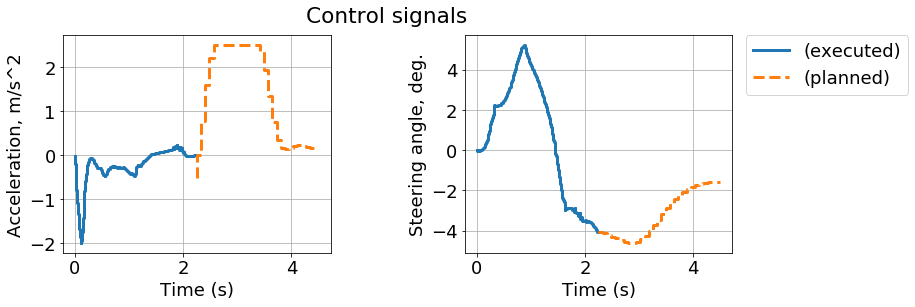

In [9]:
u_plt, u_ax1, u_ax2 = car.plot_u(u_plan, mpcprob.u_opt)

## x-y plot of car's path
Arrows show velocity. Orange components are planned but not executed.

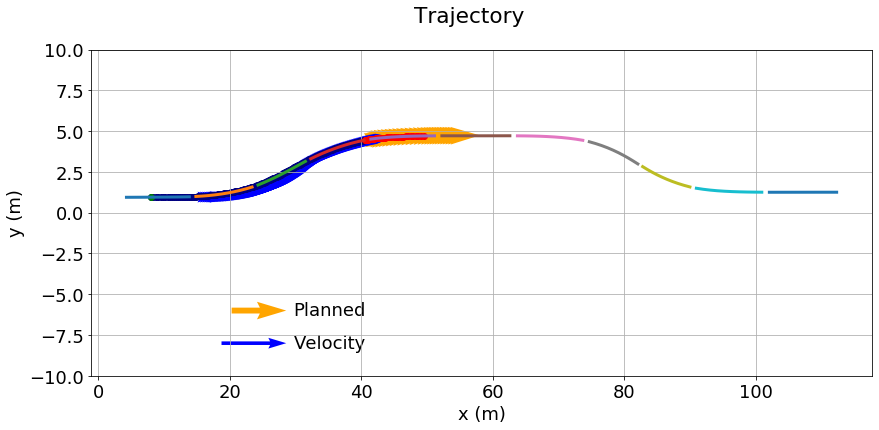

In [10]:
x_plt, x_ax = car.plot_x(x_plan, mpcprob.x_opt)
    
roadrunner.plot(ax=x_ax)
x_ax.scatter(ic[0], ic[1], color="green")
plt.ylim(-10,10)
plt.show()

## x vs time and y vs time, separately, with the boundaries

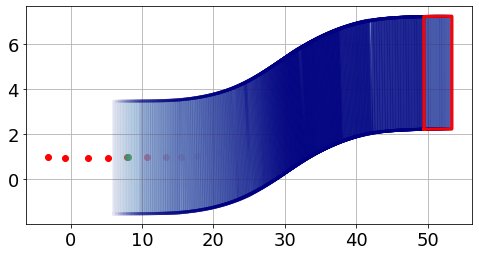

In [11]:
# Plot the road boundary as polygons
def plot_polygons(polygon_boundaries, ax=None):
    n_polys,_,_ = np.shape(polygon_boundaries)
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(8,4))
        
    for k in range(n_polys):
        # Plot the polygon fill
        ax.fill(polygon_boundaries[k,:,0], polygon_boundaries[k,:,1], "lightblue", alpha=0.1+(k/(n_polys)/2))
        # Plot the line around each polygon
        ax.plot(np.concatenate([polygon_boundaries[k,:,0],polygon_boundaries[k,0:1,0]]),
                np.concatenate([polygon_boundaries[k,:,1],polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.1+k/(n_polys)/2)

    # Plot the last polygon in RED
    ax.plot(np.concatenate([polygon_boundaries[-1,:,0],polygon_boundaries[-1,0:1,0]]),
            np.concatenate([polygon_boundaries[-1,:,1],polygon_boundaries[-1,0:1,1]]),
            color="red", alpha=1)
    return ax

ax = plot_polygons(polygon_boundaries)
ax.scatter(test_road[0:15,0], test_road[0:15,1], color='red')
ax.scatter(ic[0], ic[1], color="green")

p [[ 5.3665481  -1.55264319]
 [ 5.35604119  3.44734577]
 [ 9.20669045  3.45534241]
 [ 9.21719736 -1.54464655]]
Constraint with lower bound  -inf upper  -0.0
Constraint with lower bound  -3.0 upper  inf
Constraint with lower bound  -0.0 upper  inf
Constraint with lower bound  -inf upper  3.0
At point [[7.30490217 0.95093645]]
[ 3.30490217  4.19379106  5.08267995  5.97156883  6.86045772  7.74934661
  8.6382355   9.52712439 10.41601328 11.30490217]
ub, a, b, c, lb -0.0 -475.8761057341585 -1.0 2552.259368305807 -inf
ub, a, b, c, lb inf 0.002076700908116172 -1.0 3.4362228721682393 -3.0
ub, a, b, c, lb inf -475.8761057341183 -1.0 4384.699339935093 -0.0
ub, a, b, c, lb 3.0 0.0020767009081161716 -1.0 -1.563787908013257 -inf
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        8
Num

(-10, 20)

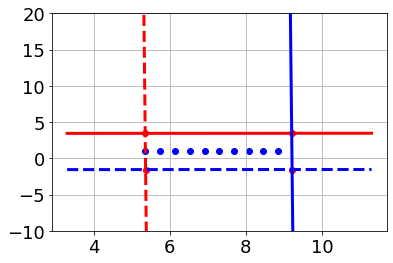

In [12]:
# Test - find a feasible point inside one polygon, to prove they work

i = 10
roadrunner.reset()
roadrunner.advance(mpcprob.model.step*np.sum(mpcprob.model.state_estimate[2,:i]))
bounds, p = bound_x(car, 0)
print("p", p)
x = casadi.MX.sym("x", 2)
lbg = []; ubg = []; g = [];

fig, ax = plt.subplots(1,1)


for (ub, a, b, c, lb) in bounds:
    print("Constraint with lower bound ", lb, "upper ", ub)
    lbg.append(np.reshape(lb,(1,)))
    ubg.append(np.reshape(ub,(1,)))
    g.append(x[0]*a + x[1]*b + c)
xy = roadrunner.evaluate()
print("At point", xy)
xl = np.linspace(xy[0,0]-4, xy[0,0]+4,10)
print(xl)
for (ub, a, b, c, lb) in bounds:
    print("ub, a, b, c, lb", ub, a, b, c, lb)
    if np.isinf(lb): # it is an upper bound
        if np.sign(a) == 1:
            ax.plot(xl, (xl*a + c)/(-b), label="upper"+str(i), color="blue", linestyle='--')
        else:
            ax.plot(xl, (xl*a + c)/(-b), label="upper"+str(i), color="red", linestyle='--')
    else:            # it is a lower bound
        if np.sign(a) == 1:
            ax.plot(xl, (xl*a + c)/(-b), label="lower"+str(i), color="red")
        else:
            ax.plot(xl, (xl*a + c)/(-b), label="lower"+str(i), color="blue")


plt.scatter(p[:,0], p[:,1], color="red")
for k in range(-5,5):
    xy = roadrunner.evaluate(mpcprob.model.step*5*k)
    plt.scatter(xy[0,0], xy[0,1], color="blue")
#for (ub, a, b, c, lb) in lowers:
#    ubg.append(np.array([np.inf,]))
#    lbg.append(np.zeros((1,)))
#    g.append(x[0]*a + x[1]*b + c)

ubg = np.concatenate(ubg)
lbg = np.concatenate(lbg)
g = casadi.vertcat(*g)

J = x[0]**2 + x[1]**2

# Create an NLP solver
prob = {'f': J, 'x': x, 'g': g}
solver = casadi.nlpsol('solver', 'ipopt', prob, {'verbose':False});

# Solve the NLP
sol = solver(x0=[2,1], lbx=-np.inf, ubx=np.inf, lbg=lbg, ubg=ubg)
print(sol['x'])
plt.ylim([-10,20])